In [1]:
import os,sys
import csv
import copy
import math
import collections
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from clawpack import pyclaw
from clawpack import riemann
from IPython.display import HTML
import numpy as np
from scipy.integrate import simps, trapz
from scipy.interpolate import interp1d
from scipy import signal
sys.path.append("/pymorph")

import logging
logger = logging.getLogger('pyclaw')
logger.setLevel(logging.CRITICAL)

import morph_geom_lib as mgl
import models.shallow_depth_morph_models as sdmodels
import schemes.avalanche_scheme 
import utils.post_processing as post



from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import display, Math, Latex
from matplotlib import animation, rc

import schemes.weno as weno
import sediment_transport.sed_trans as sedtrans
from schemes.avalanche_scheme import avalanche_model, get_slope
from models.shallow_water_solver import shallow_water_solver

rc('animation', html='html5')
%matplotlib widget
%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.style.use(['default'])

dx: 1.0008340283569641 cm
nx 1200


Text(0, 0.5, 'z (m)')

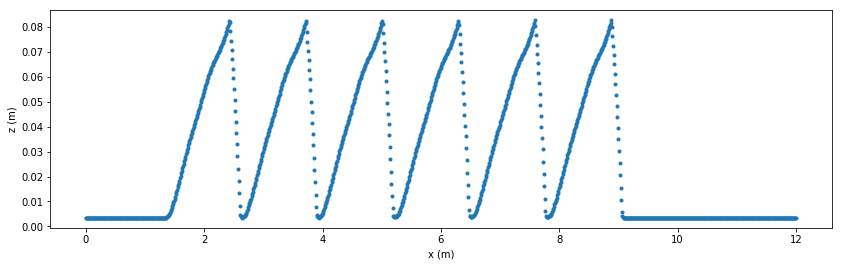

In [2]:
filepath = '../Paper_3/dune_profile_dune5_rep_runway.txt'

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    


def readFile(filepath, resolution_cells = 800):
    xs = []
    zs = []
    with open(filepath) as f:
        for line in f:
            values = line.split(',')
            if is_number(values[0]) and is_number(values[1]):
                x = float(values[0])
                z = float(values[1])
                xs.append(x)
                zs.append(z)
                
    xs = np.array(xs)
    zs = np.array(zs)
    
    #--------------------------------
    # Increase the resolution on the grid
    #--------------------------------
    xmax = xs.max()
    nx = len(xs)
    f = interp1d(xs, zs)
    
    xnew = np.linspace(0., xmax, num=resolution_cells)
    znew = f(xnew)
    return xnew, znew

x0,z0 = readFile(filepath, resolution_cells = 1200)

dx = x0[1] - x0[0]

print('dx: {0} cm'.format(dx*100.))
print('nx {0}'.format(len(x0)))

fig = plt.figure(figsize=(14, 4))
plt.plot(x0,z0, '.')
plt.xlabel('x (m)')
plt.ylabel('z (m)')

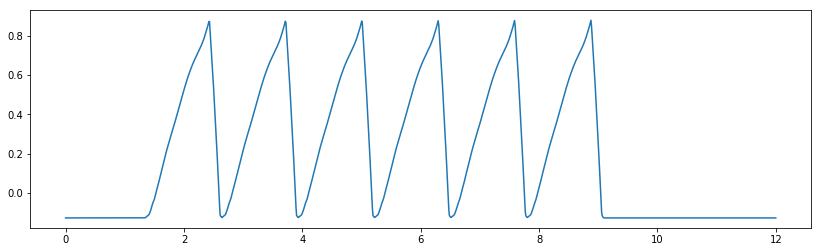

In [3]:

zn = [(zs - 0.0134)/0.079 for zs in z0]
fig = plt.figure(figsize=(14, 4))
plt.plot(x0, zn)

## 32 cm Flow Case

This is the basic case. The z was transformed to a qsb to achieve the desired migration rate. The migration rate was extracted from the graph of profiles (guess I could have done it more accurately from the actual data)? The measured migration rate was 0.95 m/hr. The model uses the following:  qbedload = [((zs - 0.0134)/0.079 * 0.0000127) for zs in z]



In [4]:
#--------------------------------
# Set up the bed properties
#--------------------------------
D50 = 0.001
repose_angle = 30.
rho_particle = 2650.
nP = 0.4

#--------------------------------
# Set up the Boundary conditions
#--------------------------------
# 32 cm Case 
Qc132 = 0.0455
Qc120 = 0.020
B = 0.76
Qtotal32 = Qc132 * 3.
Qtotal20 = Qc120 * 3.
q32cm = Qtotal32 / B
q20cm = Qtotal20 / B

sOut32 = 0.357
sOut20 = 0.237

#--------------------------------
# Set up the Flow Proerties
#--------------------------------
mannings_n = 0.024
bed_slope = 1.26/1000.
ks=0.0033

In [5]:
#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 60*300       # Runtime in seconds
dt = 2                # Time step size (s)
nt = int(simTime/dt)  # Number of time steps
extractionTime = 60.*1

run_name = 'dune_5_Parameterized_{0}_v01'.format('32cm')

model = sdmodels.ParameterizedMorphologicalModel()

#--------------------------------
# Set up the geometry
#--------------------------------
xc = x0.copy()
zc = z0.copy()
nx = len(xc)

model.setup_domain(x0, z0, dx)
model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)
model.flow_boundary_conditions(q32cm, sOut32)
model.setup_chezy_hydro_model(ks, bed_slope)

#--------------------------------
# Set up the Morphodynamic Proerties
#--------------------------------
#morph_model = sdmodels.EulerWenoModel()
morph_model = sdmodels.TVD2ndWenoModel()
model.setup_morpho_model( morph_model, 
                           useAvalanche = True, 
                           useSmoother = False, 
                           sed_model='bagnold', 
                           useSlopeAdjust = False)


zc, u, q, h, qbedload = model.run(simTime, dt, extractionTime, None)
surf = zc + h



df = model.get_wave_dataframe()
df.to_csv('_output/{0}_waves.csv'.format(run_name))
np.save('_output/{0}_z.npy'.format(run_name),zc)
verts = model._verts
np.save('_output/{0}_verts.npy'.format(run_name, verts),verts)


fig = plt.figure(figsize=(14, 6))
plt.plot(xc,zc)
plt.plot(x0,z0)
plt.plot(xc, surf)

plt.xlabel('x (m)')
plt.ylabel('z (m)')

 Starting simulation....
Number of time steps: 150.0 mins
Grid dx = 0.010008340283569641
Grid nx = 1200
Initializing hydrodynamic model...
Completed the intialization of the model
D50:    0.001
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Time step: 1.0 mins - uavg: 0.0 - Elevation 0.02897764970809008
Courant number: max 0.02149487814480013, mean0.005286736520252709
Time step: 2.0 mins - uavg: 0.0 - Elevation 0.028977649708090077
Courant number: max 0.03828739554156696, mean0.005714065368899424
Time step: 3.0 mins - uavg: 0.0 - Elevation 0.028977649708090077
Courant number: max 0.023298310958461313, mean0.006122024783843802
Time step: 4.0 mins - uavg: 0.0 - Elevation 0.028977649708090077
Courant number: max 0.02562261242474525, mean0.006575627261436415
Time step: 5.0 mins - uavg: 0.0 - Elevation 0.028977649708091847
Courant number: max 0.026647960037993485, mean0.007042819589384862
Time step: 6.0 mins - uavg: 0.0 - Elevation 0.028977649708125018
Courant number: max 0.028409516

ValueError: too many values to unpack (expected 5)

In [ ]:
run_name = 'dune_5_Parameterized_v01'.format('32m','357mm')
verts = model._verts
np.save('_output/{0}_verts.npy'.format(run_name, verts),verts)
verts = np.load('_output/{0}_verts.npy'.format(run_name))


dx = x0[1] - x0[0]
post.plot_results(verts, dx, dt, extractionTime)

In [ ]:
post.make_animation(verts)

In [ ]:
peaks_0, _ = find_peaks(z0, height = z0.mean()*0.8, distance = int(1.2/dx))
peaks_0

In [ ]:
peaks_final, _ = find_peaks(zc, height = zc.mean()*0.8, distance = int(1.2/dx))
peaks_final

In [ ]:
for i in range(len(peaks_0)):
    print( dx * (peaks_final[i] - peaks_0[i])/(0.5))

In [ ]:
qbedload_32 = [((zs - 0.0134)/0.079 * 0.0000127) for zs in z0]
fig = plt.figure(figsize=(14, 6))
plt.plot(x0, qbedload_32)

phases = weno.get_Phase_Speeds(qbedload_32, z0, 0.4)



In [ ]:
phases = weno.get_Phase_Speeds(qbedload_32, z0, 0.4)
fig = plt.figure(figsize=(14, 6))
plt.plot(x0, phases)

## Transition

qbedload = np.zeros(len(x))
        
        a = 0.00002
        b = 2
        c = 1.
        d = -0.15
        
        # So the dune height is 7.9 cm - make the q - 0.00001 at the max height 
        # This will essentially calibrate the model
 
        # For 32 cm case
        qbedload = [((zs - 0.0134)/0.079 * 0.0000127) for zs in z]
        
        
        ''' t = self._time / 60.
        for i in range(self._nx):            
            znorm = (z[i])/0.079
            
            qbedload[i] = a*znorm**(c*math.exp(d*(t))+ 1)'''  

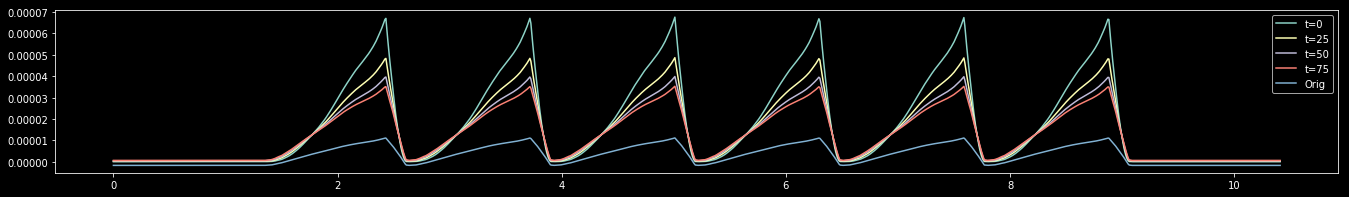

In [110]:
a = 0.0000127
b = 2
c = 1.
d = -0.02

fig = plt.figure(figsize=(23, 3))
for t in range(0, 100, 25):
    qbedload = [a*(z/0.036)**(c*math.exp(d*(t))+ 1) for z in z0]
    plt.plot(x0, qbedload, label='t={0}'.format(t))
    
plt.plot(x0, qbedload_32, label='Orig')
plt.legend()



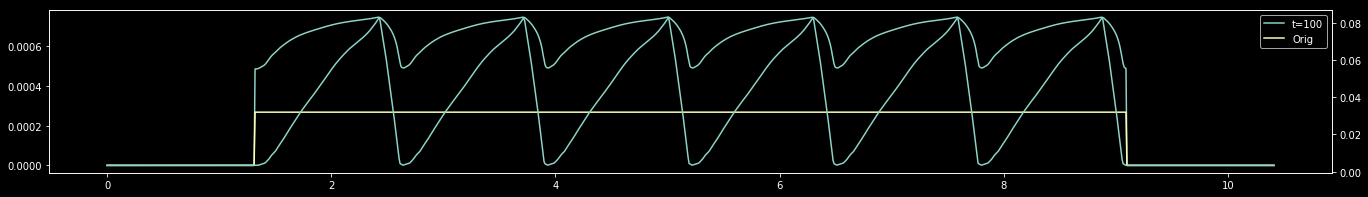

In [134]:
a = 0.0000127
b = 2
c = 1.
d = -0.02

fig,ax1 = plt.subplots(figsize=(23, 3))
#for t in range(0, 102, 25):
t = 100
qbedload = [a*(z/0.036)**(c*math.exp(d*(t))+ 1) for z in z0]
phases = weno.get_Phase_Speeds(qbedload, z0, 0.4)
plt.plot(x0, phases, label='t={0}'.format(t))
    
phases32 = weno.get_Phase_Speeds(qbedload_32, z0, 0.4)
plt.plot(x0, phases32, label='Orig')
plt.legend()

ax2 = ax1.twinx()
ax2.plot(x0, z0)


In [91]:
#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 60*300     # Runtime in seconds
dt = 1.0                # Time step size (s)
nt = int(simTime/dt)  # Number of time steps
extractionTime = 60.*1

run_name = 'dune_5_Parameterized_{0}_v01'.format('20cm')

model = sdmodels.ParameterizedMorphologicalModel()

#--------------------------------
# Set up the geometry
#--------------------------------
xc = x0.copy()
zc = z0.copy()
nx = len(xc)

model.setup_domain(x0, z0, dx)
model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)
model.flow_boundary_conditions(q32cm, sOut32)
model.setup_chezy_hydro_model(ks, bed_slope)

#--------------------------------
# Set up the Morphodynamic Proerties
#--------------------------------
#morph_model = sdmodels.EulerWenoModel()
morph_model = sdmodels.TVD2ndWenoModel()
model.setup_morpho_model( morph_model, 
                           useAvalanche = True, 
                           useSmoother = False, 
                           sed_model='bagnold', 
                           useSlopeAdjust = False)


zc, u, q, h, qbedload = model.run(simTime, dt, extractionTime, None)
surf = zc + h



df = model.get_wave_dataframe()
df.to_csv('_output/{0}_waves.csv'.format(run_name))
np.save('_output/{0}_z.npy'.format(run_name),zc)
verts = model._verts
np.save('_output/{0}_verts.npy'.format(run_name, verts),verts)


fig = plt.figure(figsize=(14, 6))
plt.plot(xc,zc)
plt.plot(x0,z0)
plt.plot(xc, surf)

plt.xlabel('x (m)')
plt.ylabel('z (m)')

 Starting simulation....
Number of time steps: 300.0 mins
Grid dx = 0.010008340283569641
Grid nx = 1200
Initializing hydrodynamic model...
Completed the intialization of the model
D50:    0.001
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
60.0 0.01789511769994243 12.0
Time step: 1.0 mins - uavg: 0.0 - Elevation 0.028977649708090077
Courant number: max 0.005851738171225874, mean0.0017402936034026713
120.0 0.03213427376606002 12.0
Time step: 2.0 mins - uavg: 0.0 - Elevation 0.028977649708090077
Courant number: max 0.006220884938801656, mean0.001875971245601054
180.0 0.05704542739232608 12.0
Time step: 3.0 mins - uavg: 0.0 - Elevation 0.028977649708090077
Courant number: max 0.00660539792421358, mean0.0020184569504766332
240.0 0.0992871645362476 12.0
Time step: 4.0 mins - uavg: 0.0 - Elevation 0.028977649708090077
Courant number: max 0.007012899855867249, mean0.002167819635052555
300.0 0.1672602499669491 12.0
Time step: 5.0 mins - uavg: 0.0 - Elevation 0.028977649708090077
Couran

KeyboardInterrupt: 

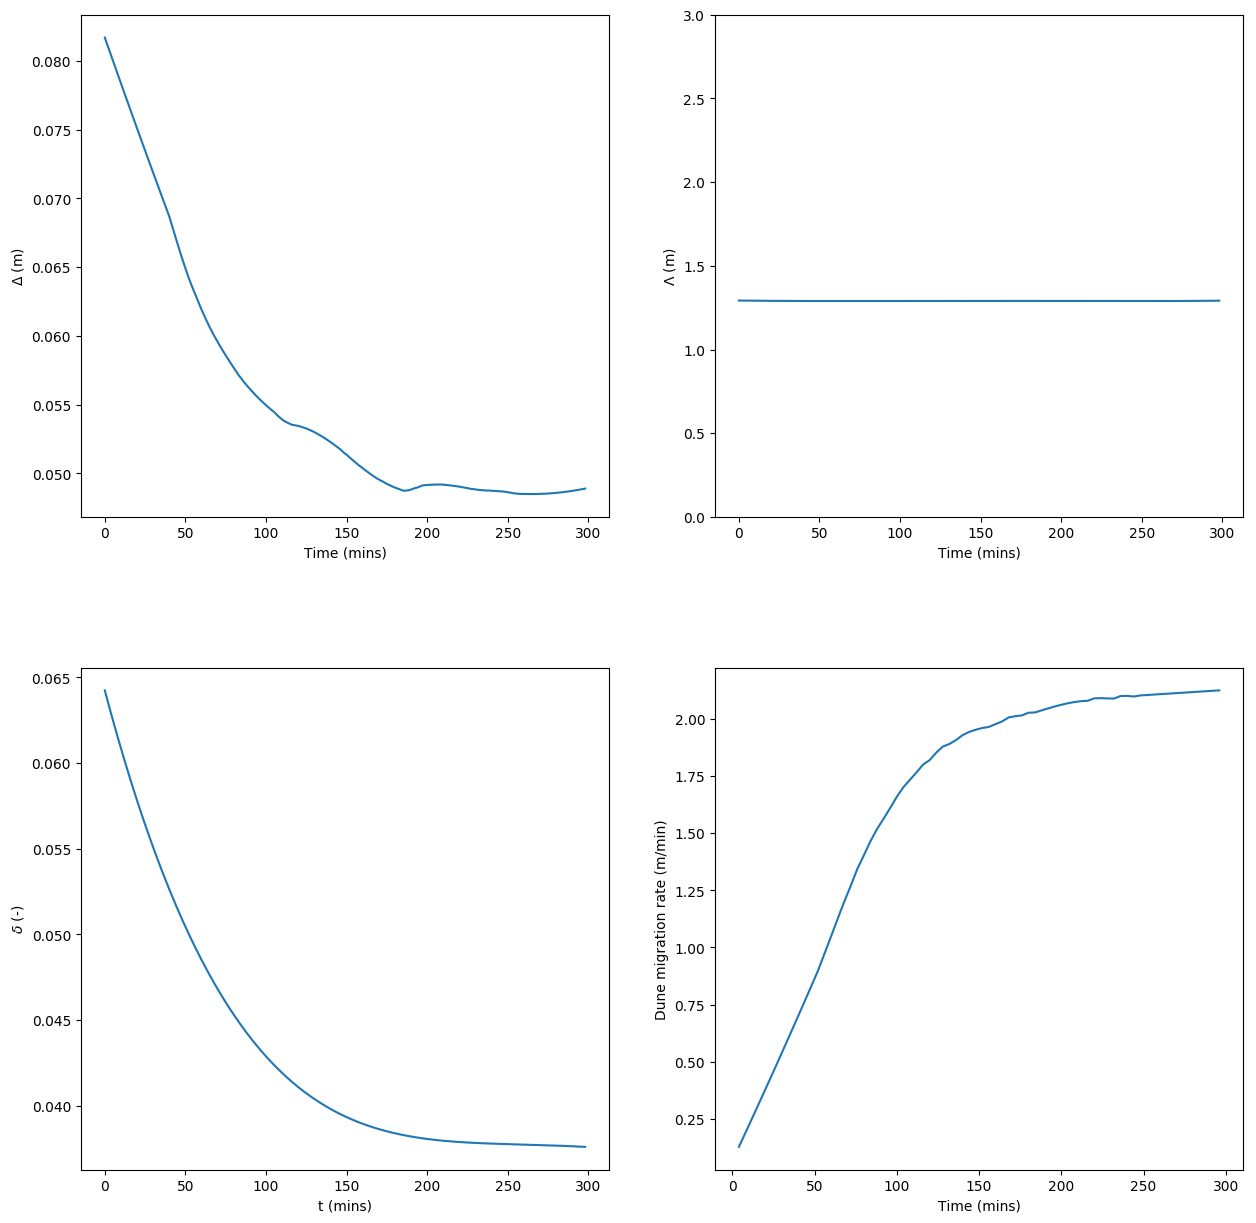

In [77]:
run_name = 'dune_5_Parameterized_v01'.format('32m','357mm')
verts = model._verts
np.save('_output/{0}_verts.npy'.format(run_name, verts),verts)
verts = np.load('_output/{0}_verts.npy'.format(run_name))


dx = x0[1] - x0[0]
post.plot_results(verts, dx, dt, extractionTime)

2019-06-15 15:57:20,955 INFO CLAW: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2019-06-15 15:57:20,956 INFO CLAW: MovieWriter.run: running command: ['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '864x216', '-pix_fmt', 'rgba', '-r', '12.5', '-loglevel', 'quiet', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/tmp/tmpaczx3z03/temp.m4v']


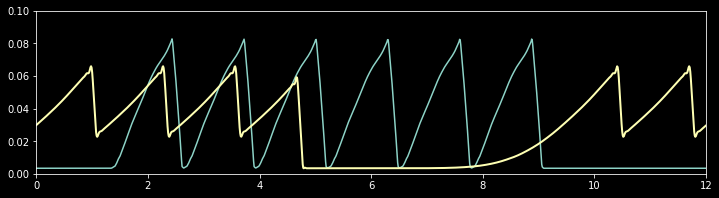

In [35]:

verts = model._verts
np.save('_output/{0}_verts.npy'.format(run_name),verts)
verts = np.load('_output/{0}_verts.npy'.format(run_name))

post.make_animation(verts)

 Starting simulation....
Number of time steps: 30.0 mins
Grid dx = 0.010008340283569641
Grid nx = 1200
Initializing hydrodynamic model...
Completed the intialization of the model
D50:    0.001
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Time step: 0.16666666666666666 mins - uavg: 0.0 - Elevation 0.028977649708090077
Courant number: max 0.00980986785559578, mean0.0024818034422696834
Time step: 0.3333333333333333 mins - uavg: 0.0 - Elevation 0.028977649708090077
Courant number: max 0.03817354946163678, mean0.0025393189836246987
Time step: 0.5 mins - uavg: 0.0 - Elevation 0.028977649708090077
Courant number: max 0.010117546730223904, mean0.0025469959941096672
Time step: 0.6666666666666666 mins - uavg: 0.0 - Elevation 0.028977649708090077
Courant number: max 0.010287961793720492, mean0.00257627238011024
Time step: 0.8333333333333334 mins - uavg: 0.0 - Elevation 0.028977649708090077
Courant number: max 0.010959973003997323, mean0.00261414884805836
Time step: 1.0 mins - uavg: 0.0 -

Text(0, 0.5, 'z (m)')

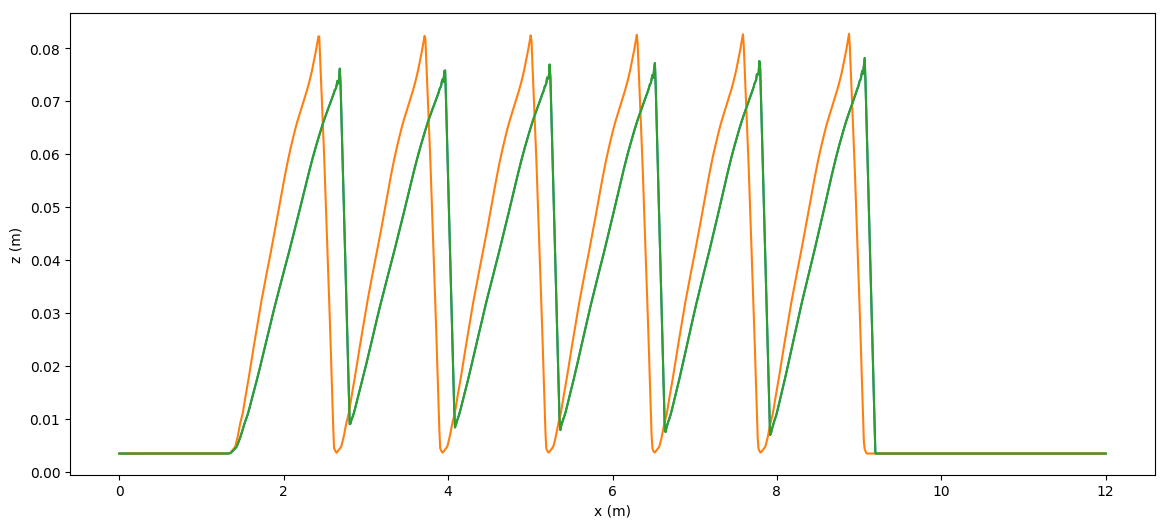

In [123]:
#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 60*30    # Runtime in seconds
dt = 1.0                # Time step size (s)
nt = int(simTime/dt)  # Number of time steps
extractionTime = 10

run_name = 'dune_5_Parameterized_{0}_v01'.format('20cm')

model = sdmodels.ParameterizedMorphologicalModel()

#--------------------------------
# Set up the geometry
#--------------------------------
xc = x0.copy()
zc = z0.copy()
nx = len(xc)

model.setup_domain(x0, z0, dx)
model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)
model.flow_boundary_conditions(q32cm, sOut32)
model.setup_chezy_hydro_model(ks, bed_slope)

#--------------------------------
# Set up the Morphodynamic Proerties
#--------------------------------
#morph_model = sdmodels.EulerWenoModel()
morph_model = sdmodels.TVD2ndWenoModel()
model.setup_morpho_model( morph_model, 
                           useAvalanche = True, 
                           useSmoother = False, 
                           sed_model='bagnold', 
                           useSlopeAdjust = False)


xc, zc, u, q, h, qbedload = model.run(simTime, dt, extractionTime, None)
surf = zc + h



df = model.get_wave_dataframe()
df.to_csv('_output/{0}_waves.csv'.format(run_name))
np.save('_output/{0}_z.npy'.format(run_name),zc)
verts = model._verts
np.save('_output/{0}_verts.npy'.format(run_name, verts),verts)


fig = plt.figure(figsize=(14, 6))
plt.plot(xc,zc)
plt.plot(x0,z0)
plt.plot(xc, surf)

plt.xlabel('x (m)')
plt.ylabel('z (m)')


ValueError: Delta was zero

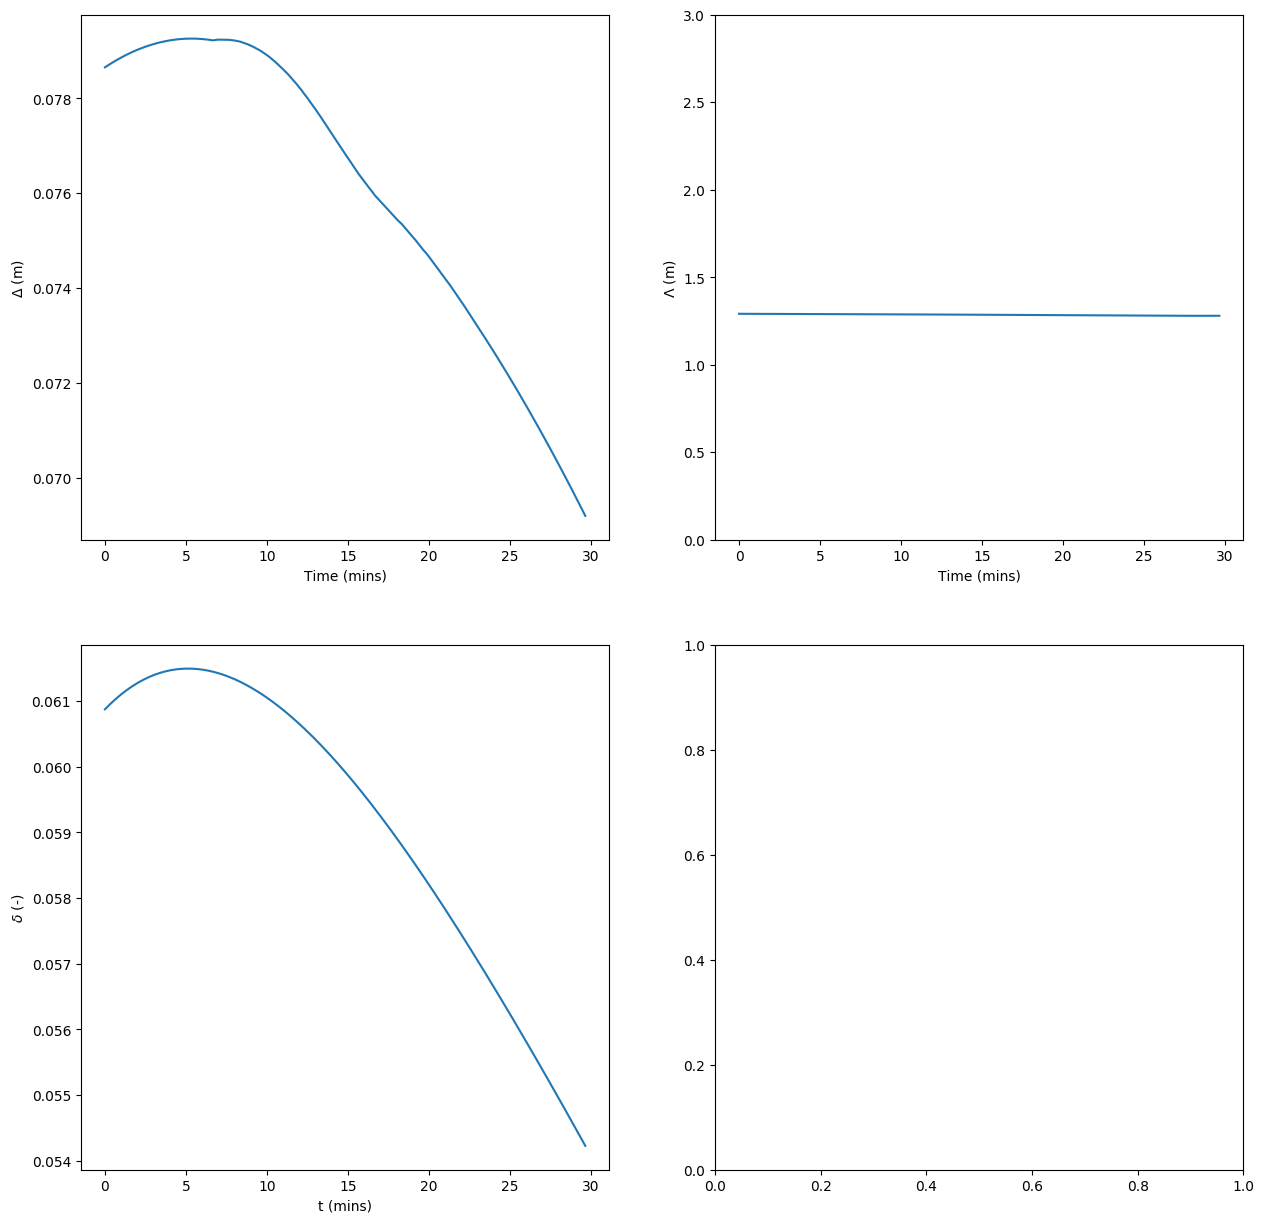

In [124]:
run_name = 'dune_5_Parameterized_{0}_v01'.format('20cm')
verts = model._verts
np.save('_output/{0}_verts.npy'.format(run_name, verts),verts)
verts = np.load('_output/{0}_verts.npy'.format(run_name))


dx = x0[1] - x0[0]
post.plot_results(verts, dx, dt, extractionTime)

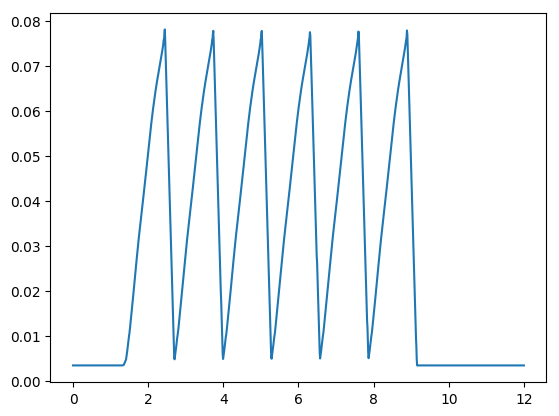

In [85]:
plt.plot(xc,zc)

In [86]:
xc.max(), x0.max()

(12.0, 12.0)